Shorten Code (FOR EDA)

In [1]:
from datetime import datetime
import pandas as pd
import re

df_1 = pd.read_csv('data.csv', delimiter=',', encoding='ISO-8859-1')
df_2 = pd.read_csv('ecommerce.csv', delimiter=',', encoding='ISO-8859-1')

df_2 = df_2.drop(columns=['age', 'gender', 'source'])

df_2 = df_2.rename(columns={
    'quantity' : 'Quantity', 
    'price' : 'UnitPrice',
    'user_id' : 'CustomerID',
    'order_id' : 'InvoiceNo',
    'created_at' : 'InvoiceDate',
    'country' : 'Country', 
    'product_id' : 'StockCode',
    'category' : 'Description'
})

order = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

df_2['InvoiceDate'] = df_2['InvoiceDate'].str.replace(' UTC', '', regex=False)
df_2['InvoiceDate'] = df_2['InvoiceDate'].apply(lambda x: re.sub(r'\.\d{6}', '', x))
df_2['InvoiceDate'] = pd.to_datetime(df_2['InvoiceDate'], errors='coerce')
df_2['InvoiceDate'] = df_2['InvoiceDate'].dt.strftime('%Y-%m-%d %H:%M')

df_2 = df_2[order]

df_2['InvoiceNo'] = df_2['InvoiceNo'].astype('object')
df_2['StockCode'] = df_2['StockCode'].astype('object')
df_2['CustomerID'] = df_2['CustomerID'].astype('float64')

df_1.dropna(inplace=True)
df_2.dropna(inplace=True)

df_1.drop(df_1[df_1['Quantity'] < 0].index, inplace=True)  # remove all quantity that is negative and unit price that is negative
df_1.drop(df_1[df_1['UnitPrice'] < 0].index, inplace=True) 
df_2.drop(df_2[df_2['Quantity'] < 0].index, inplace=True)  
df_2.drop(df_2[df_2['UnitPrice'] < 0].index, inplace=True) 

df_1['TotalAmount']= df_1['Quantity']*df_1['UnitPrice']
tm_1 = df_1.groupby('CustomerID')['TotalAmount'].sum().reset_index()
df_2['TotalAmount']= df_2['Quantity']*df_2['UnitPrice']
tm_2 = df_2.groupby('CustomerID')['TotalAmount'].sum().reset_index()

nt_1 =df_1.groupby('CustomerID')['InvoiceNo'].count().reset_index()
nt_2 =df_2.groupby('CustomerID')['InvoiceNo'].count().reset_index()

df_1['InvoiceDate'] = pd.to_datetime(df_1['InvoiceDate'])
df_1['Last_transaction']=(df_1['InvoiceDate'].max()-df_1['InvoiceDate']).dt.days
lt_1 = df_1.groupby(['CustomerID','Country'])['Last_transaction'].max().reset_index()
df_2['InvoiceDate'] = pd.to_datetime(df_2['InvoiceDate'])
df_2['Last_transaction']=(df_2['InvoiceDate'].max()-df_2['InvoiceDate']).dt.days
lt_2 = df_2.groupby(['CustomerID','Country'])['Last_transaction'].max().reset_index()


merge1= pd.merge(lt_1, nt_1, how='inner', on='CustomerID')
new_df_1=pd.merge(merge1,tm_1,how='inner',on= 'CustomerID')
merge2= pd.merge(lt_2, nt_2, how='inner', on='CustomerID')
new_df_2=pd.merge(merge2,tm_2,how='inner',on= 'CustomerID')

final = pd.merge(new_df_1, new_df_2, how='outer') # merge the dataframe

final

final.to_csv('non-preprocessed.csv', index=False)

In [2]:
final

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,7.0,United States,68,2,90.980000
1,12.0,Brasil,42,4,149.299999
2,18.0,United States,171,1,89.500000
3,22.0,China,171,1,135.000000
4,24.0,United States,276,6,619.080002
...,...,...,...,...,...
26570,99987.0,China,143,1,26.990000
26571,99988.0,China,147,4,811.959991
26572,99991.0,United States,97,6,2017.199997
26573,99992.0,France,295,6,369.199996


In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import re

In [4]:
df_1 = pd.read_csv('data.csv', delimiter=',', encoding='ISO-8859-1')
df_2 = pd.read_csv('ecommerce.csv', delimiter=',', encoding='ISO-8859-1')

In [5]:
df_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [6]:
df_2

,user_id,age,gender,country,source,order_id,quantity,created_at,product_id,price,category
0,13833,45,F,China,Search,17103,1,2021-12-31 00:27:00 UTC,4715,58.000000,Jeans
1,13833,45,F,China,Search,17103,1,2021-12-31 00:27:00 UTC,11341,79.989998,Intimates
2,13833,45,F,China,Search,17103,1,2021-12-31 00:27:00 UTC,12397,30.950001,Intimates
3,60200,26,M,Brasil,Search,75511,1,2021-12-31 01:02:00 UTC,23975,55.000000,Outerwear & Coats
4,60200,26,M,Brasil,Search,75511,1,2021-12-31 01:02:00 UTC,16444,44.990002,Tops & Tees
...,...,...,...,...,...,...,...,...,...,...,...
63111,3735,60,M,France,Search,4625,1,2022-12-31 18:59:00 UTC,19380,95.989998,Sweaters
63112,3735,60,M,France,Search,4625,1,2022-12-31 18:59:00 UTC,23026,27.320000,Shorts
63113,81139,39,F,United States,Search,101460,2,2022-12-31 19:43:24.359178 UTC,11774,26.000000,Intimates
63114,81139,39,F,United States,Search,101460,2,2022-12-31 19:43:24.359178 UTC,6342,46.000000,Shorts


Make the format consistent with each tables (Including dropping tables that are not needed and also their datatypes)

In [7]:
df_2 = df_2.drop(columns=['age', 'gender', 'source'])

In [8]:
df_2 = df_2.rename(columns={
    'quantity' : 'Quantity', 
    'price' : 'UnitPrice',
    'user_id' : 'CustomerID',
    'order_id' : 'InvoiceNo',
    'created_at' : 'InvoiceDate',
    'country' : 'Country', 
    'product_id' : 'StockCode',
    'category' : 'Description'
})

order = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

df_2['InvoiceDate'] = df_2['InvoiceDate'].str.replace(' UTC', '', regex=False)
df_2['InvoiceDate'] = df_2['InvoiceDate'].apply(lambda x: re.sub(r'\.\d{6}', '', x))
df_2['InvoiceDate'] = pd.to_datetime(df_2['InvoiceDate'], errors='coerce')
df_2['InvoiceDate'] = df_2['InvoiceDate'].dt.strftime('%Y-%m-%d %H:%M')

df_2 = df_2[order]

In [9]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63116 entries, 0 to 63115
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    63116 non-null  int64  
 1   StockCode    63116 non-null  int64  
 2   Description  63116 non-null  object 
 3   Quantity     63116 non-null  int64  
 4   InvoiceDate  63107 non-null  object 
 5   UnitPrice    63116 non-null  float64
 6   CustomerID   63116 non-null  int64  
 7   Country      63116 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 3.9+ MB


In [11]:
df_2['InvoiceNo'] = df_2['InvoiceNo'].astype('object')
df_2['StockCode'] = df_2['StockCode'].astype('object')
df_2['CustomerID'] = df_2['CustomerID'].astype('float64')

In [12]:
df_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [13]:
df_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,17103,4715,Jeans,1,2021-12-31 00:27,58.000000,13833.0,China
1,17103,11341,Intimates,1,2021-12-31 00:27,79.989998,13833.0,China
2,17103,12397,Intimates,1,2021-12-31 00:27,30.950001,13833.0,China
3,75511,23975,Outerwear & Coats,1,2021-12-31 01:02,55.000000,60200.0,Brasil
4,75511,16444,Tops & Tees,1,2021-12-31 01:02,44.990002,60200.0,Brasil
...,...,...,...,...,...,...,...,...
63111,4625,19380,Sweaters,1,2022-12-31 18:59,95.989998,3735.0,France
63112,4625,23026,Shorts,1,2022-12-31 18:59,27.320000,3735.0,France
63113,101460,11774,Intimates,2,2022-12-31 19:43,26.000000,81139.0,United States
63114,101460,6342,Shorts,2,2022-12-31 19:43,46.000000,81139.0,United States


In [14]:
df_1.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [15]:
df_2.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    9
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Remove All Null Values

In [16]:
df_1.dropna(inplace=True)
df_2.dropna(inplace=True)

Check Less Than 0 Values (Price and QUantity Cannot Be 0)

In [17]:
df_1.drop(df_1[df_1['Quantity'] < 0].index, inplace=True)  # remove all quantity that is negative and unit price that is negative
df_1.drop(df_1[df_1['UnitPrice'] < 0].index, inplace=True) 
print(df_1[df_1['Quantity']<0].shape[0], df_1[df_1['UnitPrice']<0].shape[0]) # double check again

df_2.drop(df_2[df_2['Quantity'] < 0].index, inplace=True)  # remove all quantity that is negative and unit price that is negative
df_2.drop(df_2[df_2['UnitPrice'] < 0].index, inplace=True) 
print(df_2[df_2['Quantity']<0].shape[0], df_2[df_2['UnitPrice']<0].shape[0]) # double check again

0 0
0 0


Total Amount (Total Spent From Each Customer)

In [18]:
df_1['TotalAmount']= df_1['Quantity']*df_1['UnitPrice']
tm_1 = df_1.groupby('CustomerID')['TotalAmount'].sum().reset_index()
tm_1

,CustomerID,TotalAmount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2094.88


In [19]:
df_2['TotalAmount']= df_2['Quantity']*df_2['UnitPrice']
tm_2 = df_2.groupby('CustomerID')['TotalAmount'].sum().reset_index()
tm_2

,CustomerID,TotalAmount
0,7.0,90.980000
1,12.0,149.299999
2,18.0,89.500000
3,22.0,135.000000
4,24.0,619.080002
...,...,...
22223,99987.0,26.990000
22224,99988.0,811.959991
22225,99991.0,2017.199997
22226,99992.0,369.199996


Customer Frequency (How many times they buy)

In [20]:
nt_1 =df_1.groupby('CustomerID')['InvoiceNo'].count().reset_index()
nt_1

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4334,18280.0,10
4335,18281.0,7
4336,18282.0,12
4337,18283.0,756


In [21]:
nt_2 =df_2.groupby('CustomerID')['InvoiceNo'].count().reset_index()
nt_2

,CustomerID,InvoiceNo
0,7.0,2
1,12.0,4
2,18.0,1
3,22.0,1
4,24.0,6
...,...,...
22223,99987.0,1
22224,99988.0,4
22225,99991.0,6
22226,99992.0,6


Last Transaction

In [22]:
df_1['InvoiceDate'] = pd.to_datetime(df_1['InvoiceDate'])

df_1['MaxDate'] = df_1['InvoiceDate'].max()
df_1['dtDays'] = df_1['InvoiceDate']
df_1['Last_transaction']=(df_1['InvoiceDate'].max()-df_1['InvoiceDate']).dt.days

df_1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,MaxDate,dtDays,Last_transaction
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2011-12-09 12:50:00,2010-12-01 08:26:00,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-12-09 12:50:00,2010-12-01 08:26:00,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2011-12-09 12:50:00,2010-12-01 08:26:00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-12-09 12:50:00,2010-12-01 08:26:00,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-12-09 12:50:00,2010-12-01 08:26:00,373
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09 12:50:00,2011-12-09 12:50:00,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09 12:50:00,2011-12-09 12:50:00,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09 12:50:00,2011-12-09 12:50:00,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09 12:50:00,2011-12-09 12:50:00,0


In [23]:
lt_1 = df_1.groupby(['CustomerID','Country'])['Last_transaction'].max().reset_index()
lt_1

,CustomerID,Country,Last_transaction
0,12346.0,United Kingdom,325
1,12347.0,Iceland,366
2,12348.0,Finland,357
3,12349.0,Italy,18
4,12350.0,Norway,309
...,...,...,...
4342,18280.0,United Kingdom,277
4343,18281.0,United Kingdom,180
4344,18282.0,United Kingdom,125
4345,18283.0,United Kingdom,336


In [24]:
lt_1.to_csv('lt1.csv', index=False)

In [25]:
df_2['InvoiceDate'] = pd.to_datetime(df_2['InvoiceDate'])
df_2['Last_transaction']=(df_2['InvoiceDate'].max()-df_2['InvoiceDate']).dt.days
lt_2 = df_2.groupby(['CustomerID','Country'])['Last_transaction'].max().reset_index()
lt_2

lt_2.to_csv('lt2.csv', index=False)

In [26]:
merge1= pd.merge(lt_1, nt_1, how='inner', on='CustomerID')
new_df_1=pd.merge(merge1,tm_1,how='inner',on= 'CustomerID')
new_df_1

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,12346.0,United Kingdom,325,1,77183.60
1,12347.0,Iceland,366,182,4310.00
2,12348.0,Finland,357,31,1797.24
3,12349.0,Italy,18,73,1757.55
4,12350.0,Norway,309,17,334.40
...,...,...,...,...,...
4342,18280.0,United Kingdom,277,10,180.60
4343,18281.0,United Kingdom,180,7,80.82
4344,18282.0,United Kingdom,125,12,178.05
4345,18283.0,United Kingdom,336,756,2094.88


In [27]:
merge2= pd.merge(lt_2, nt_2, how='inner', on='CustomerID')
new_df_2=pd.merge(merge2,tm_2,how='inner',on= 'CustomerID')
new_df_2

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,7.0,United States,68,2,90.980000
1,12.0,Brasil,42,4,149.299999
2,18.0,United States,171,1,89.500000
3,22.0,China,171,1,135.000000
4,24.0,United States,276,6,619.080002
...,...,...,...,...,...
22223,99987.0,China,143,1,26.990000
22224,99988.0,China,147,4,811.959991
22225,99991.0,United States,97,6,2017.199997
22226,99992.0,France,295,6,369.199996


Merge the datasets (since we already have all we need)

In [28]:
ywach = pd.merge(new_df_1, new_df_2, how='outer') # merge the dataframe

ywach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26575 entries, 0 to 26574
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        26575 non-null  float64
 1   Country           26575 non-null  object 
 2   Last_transaction  26575 non-null  int64  
 3   InvoiceNo         26575 non-null  int64  
 4   TotalAmount       26575 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.0+ MB


In [29]:
ywach

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,7.0,United States,68,2,90.980000
1,12.0,Brasil,42,4,149.299999
2,18.0,United States,171,1,89.500000
3,22.0,China,171,1,135.000000
4,24.0,United States,276,6,619.080002
...,...,...,...,...,...
26570,99987.0,China,143,1,26.990000
26571,99988.0,China,147,4,811.959991
26572,99991.0,United States,97,6,2017.199997
26573,99992.0,France,295,6,369.199996


# Preprocessing

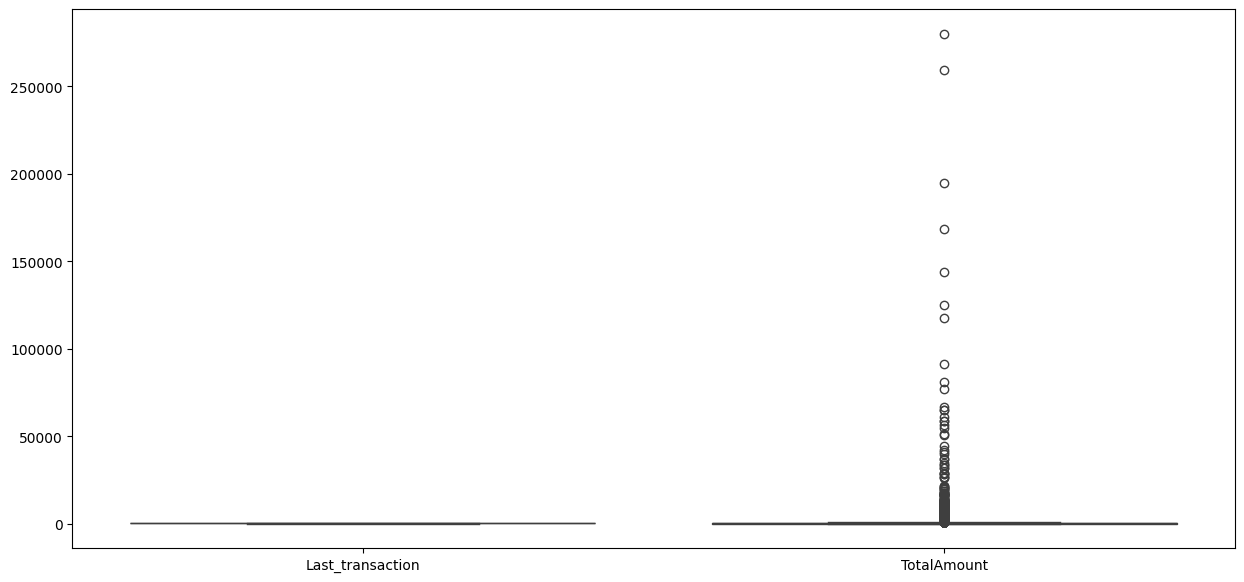

In [30]:
plt.figure(figsize=(15,7))
sns.boxplot(data = ywach[['Last_transaction','TotalAmount']])
plt.show()

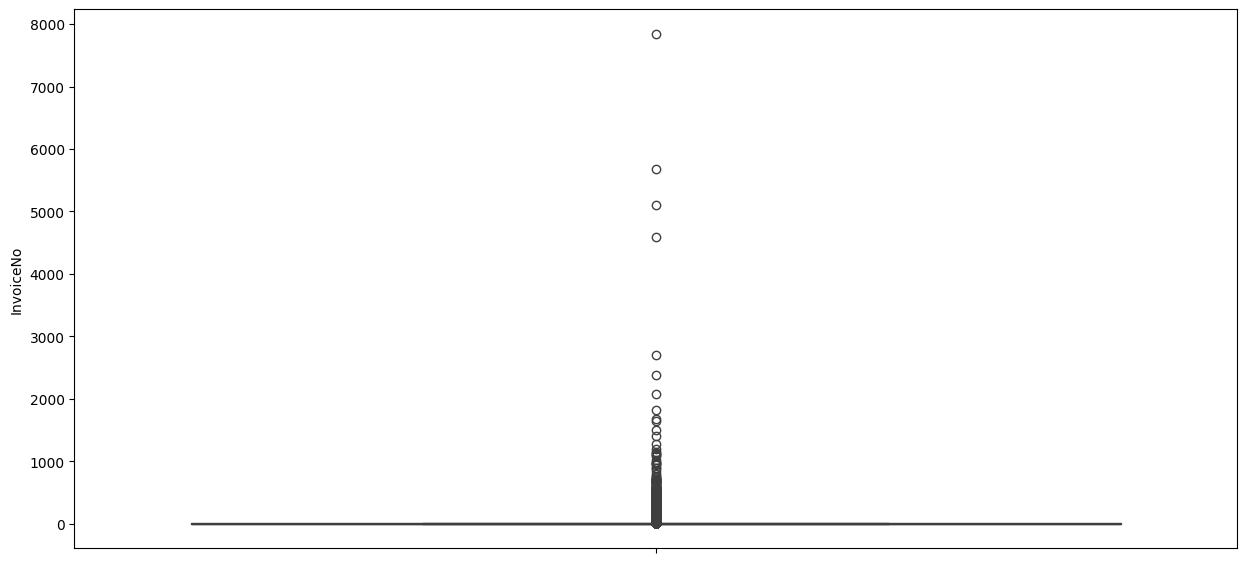

In [31]:
plt.figure(figsize=(15,7))
sns.boxplot(data = ywach['InvoiceNo'])
plt.show()

In [32]:
IQR= ywach['TotalAmount'].quantile(0.75)-ywach['TotalAmount'].quantile(0.25)
lower_limit= ywach['TotalAmount'].quantile(0.25) - 1.5*IQR
upper_limit=ywach['TotalAmount'].quantile(0.75) + 1.5*IQR
k=ywach[ywach['TotalAmount']>upper_limit]
m=ywach[ywach['TotalAmount']<lower_limit]
df_iqr=ywach[(ywach['TotalAmount']<upper_limit) & (ywach['TotalAmount']>lower_limit)]
print('Data shape before removing outlier',ywach.shape)
print('Data shape after removing outlier',df_iqr.shape)
print(upper_limit)
print(lower_limit)
print('Total number of outlier:',len(k)+len(m))

Data shape before removing outlier (26575, 5)
Data shape after removing outlier (23741, 5)
1041.9374948501586
-537.1624969100952
Total number of outlier: 2834


In [33]:
df_iqr

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,7.0,United States,68,2,90.980000
1,12.0,Brasil,42,4,149.299999
2,18.0,United States,171,1,89.500000
3,22.0,China,171,1,135.000000
4,24.0,United States,276,6,619.080002
...,...,...,...,...,...
26568,99980.0,Japan,76,3,878.969999
26570,99987.0,China,143,1,26.990000
26571,99988.0,China,147,4,811.959991
26573,99992.0,France,295,6,369.199996


Can take dataset from this point

In [34]:
df_iqr.reset_index(drop=True, inplace= True)
df_iqr
df_iqr.to_csv('theallmighty.csv', index=False)

Clustering

In [35]:
new1_df=df_iqr[['Last_transaction','InvoiceNo','TotalAmount']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new1_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns=['Last_transaction','InvoiceNo','TotalAmount']
scaled_df['Country']=df_iqr['Country']
scaled_df

,Last_transaction,InvoiceNo,TotalAmount,Country
0,0.182306,0.003425,0.087340,United States
1,0.112601,0.010274,0.143326,Brasil
2,0.458445,0.000000,0.085919,United States
3,0.458445,0.000000,0.129598,China
4,0.739946,0.017123,0.594309,United States
...,...,...,...,...
23736,0.203753,0.006849,0.843800,Japan
23737,0.383378,0.000000,0.025910,China
23738,0.394102,0.010274,0.779472,China
23739,0.790885,0.017123,0.354427,France


In [36]:
scaled_df = scaled_df.sample(n=10000, random_state=42)

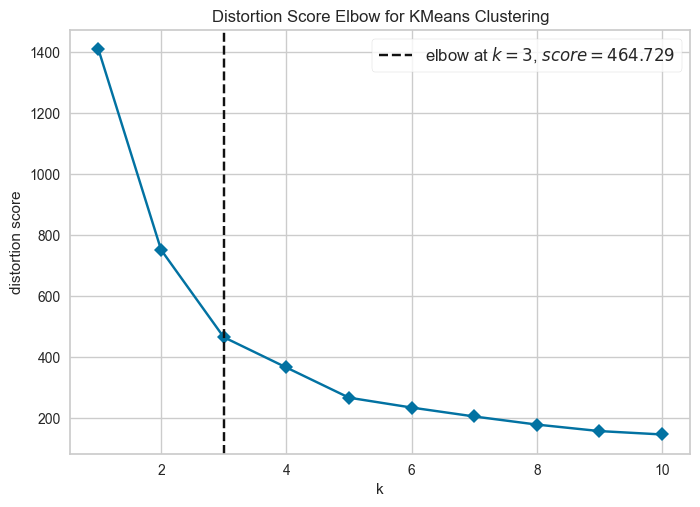

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_k)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

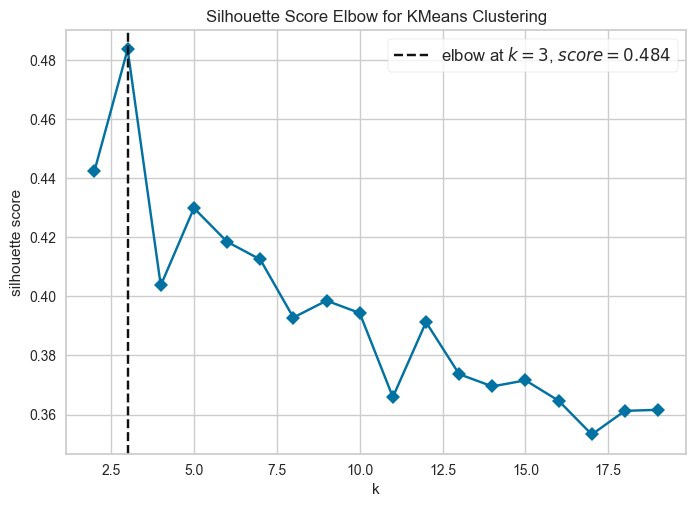

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= False)
visualizer.fit(df_k)        
visualizer.show()       

In [39]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
df_k

,Last_transaction,InvoiceNo,TotalAmount
1510,0.466488,0.000000,0.035510
20968,0.176944,0.000000,0.057599
4115,0.672922,0.037671,0.524691
19193,0.040214,0.000000,0.122878
21504,0.630027,0.037671,0.542105
...,...,...,...
11420,0.230563,0.000000,0.039599
7386,0.828418,0.000000,0.032640
16765,0.627346,0.003425,0.585593
1844,0.184987,0.003425,0.072940


In [40]:
# Add the number of cluster columns in the data frame
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_k)
df_k['clusters']= y_predicted
df_k

,Last_transaction,InvoiceNo,TotalAmount,clusters
1510,0.466488,0.000000,0.035510,1
20968,0.176944,0.000000,0.057599,1
4115,0.672922,0.037671,0.524691,2
19193,0.040214,0.000000,0.122878,1
21504,0.630027,0.037671,0.542105,2
...,...,...,...,...
11420,0.230563,0.000000,0.039599,1
7386,0.828418,0.000000,0.032640,0
16765,0.627346,0.003425,0.585593,2
1844,0.184987,0.003425,0.072940,1


In [41]:
km.cluster_centers_

array([[0.73014476, 0.00979533, 0.13917961],
       [0.20876008, 0.00885653, 0.12850876],
       [0.50415699, 0.06298177, 0.66350968]])

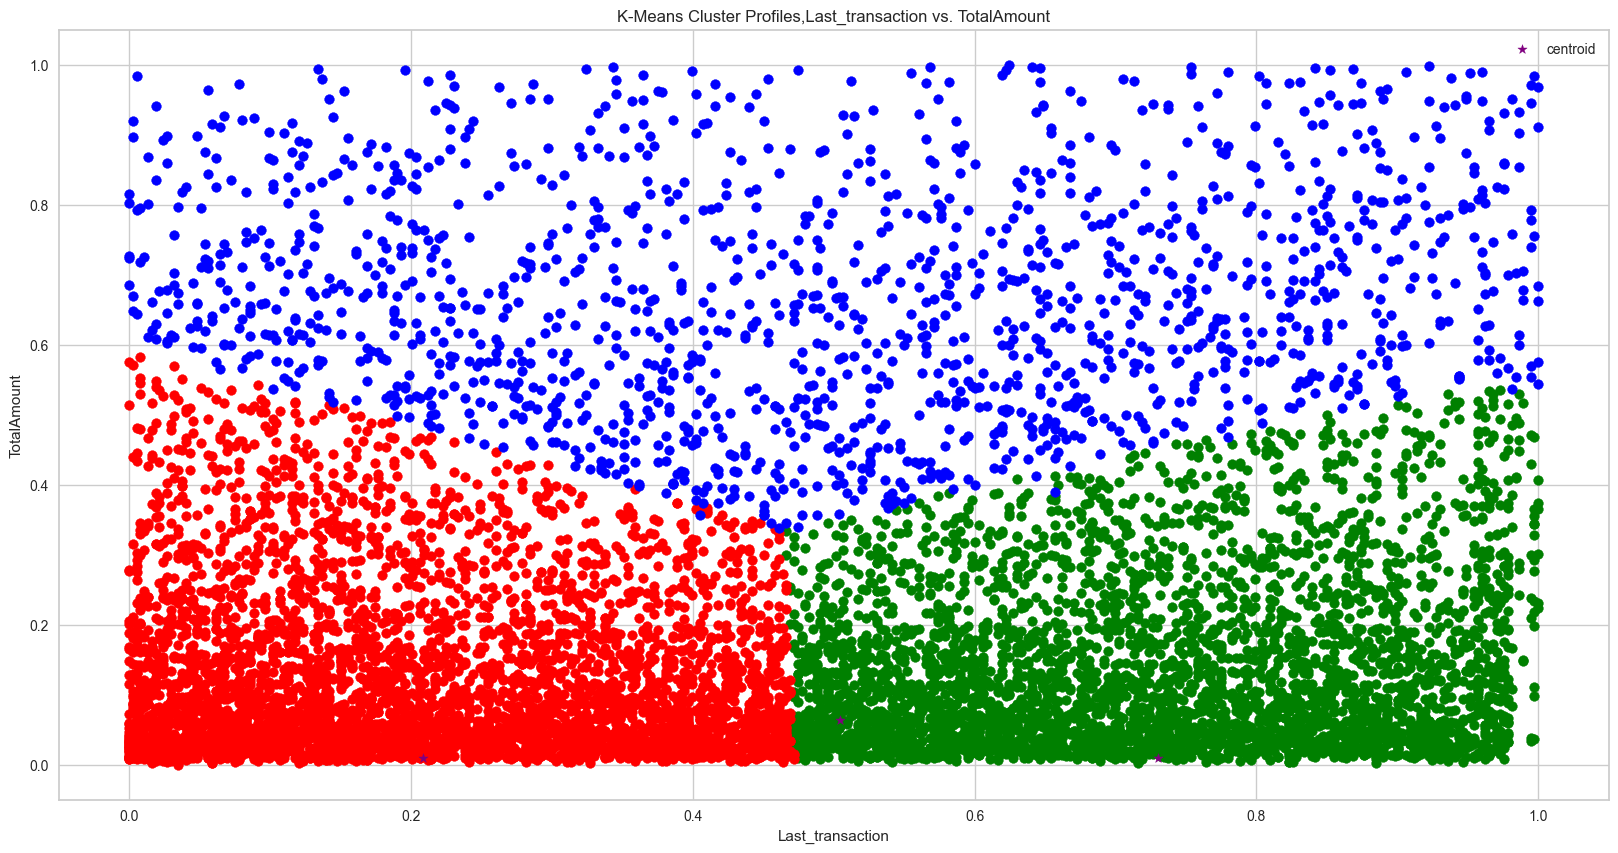

In [42]:
# Visualize the clusters with original data
df_k['clusters']= y_predicted
df1 = df_k[df_k.clusters==0]
df2 = df_k[df_k.clusters==1]
df3 = df_k[df_k.clusters==2]
plt.figure(figsize=(20,10))
plt.scatter(df1.Last_transaction,df1['TotalAmount'],color='green')
plt.scatter(df2.Last_transaction,df2['TotalAmount'],color='red')
plt.scatter(df3.Last_transaction,df3['TotalAmount'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.legend()
plt.xlabel('Last_transaction')
plt.ylabel('TotalAmount')
plt.title('K-Means Cluster Profiles,Last_transaction vs. TotalAmount')
plt.show()

Hierarchial Agglomerative CLustering

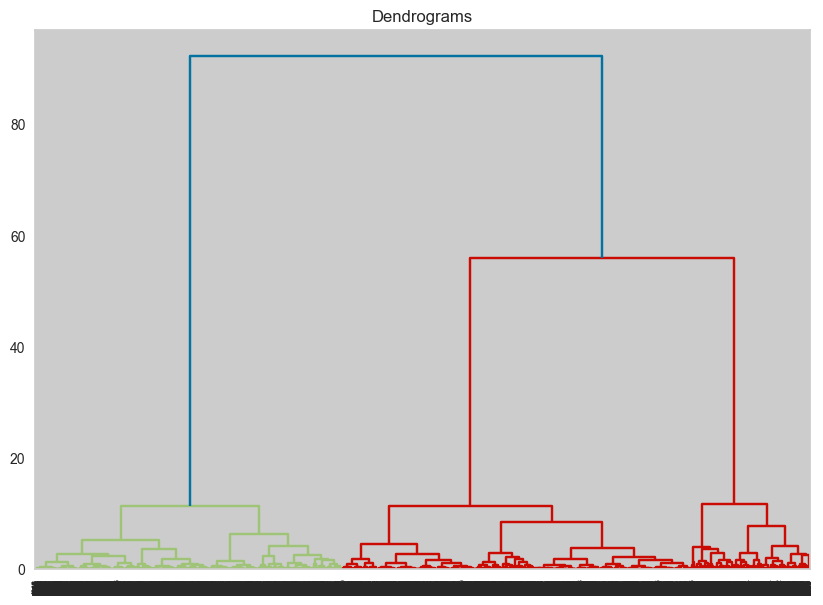

In [43]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_k, method='ward'))